In [1]:
# Importer les bibliothèques nécessaires
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, chi2_contingency
import folium  # Pour cartes interactives
from folium.plugins import HeatMap
import statsmodels.api as sm  # Pour régressions

# Charger les données (adaptez les chemins si nécessaire)
df = pd.read_csv(r"D:\Dataviz\biodiv_grand_est_merger.csv", parse_dates=['dateObservation'])
communes_grand_est = gpd.read_file(r"D:\Dataviz\02_Donnees_Secondaires\communes-grand-est.geojson")
departements_grand_est = gpd.read_file(r"D:\Dataviz\02_Donnees_Secondaires\departements-grand-est.geojson")
region_grand_est = gpd.read_file(r"D:\Dataviz\02_Donnees_Secondaires\region-grand-est.geojson")
communes = pd.read_csv(
    r"D:\Dataviz\02_Donnees_Secondaires\communes.csv",
    sep=';',  # ou ',' selon ton fichier
    engine='python'  # moteur plus tolérant
)


# Assurer que les colonnes numériques sont bien typées
numeric_cols = ['population 2025', 'urbain', 'agricole', 'naturel', 'humide', 'eau']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Ajouter mois, année, saison si pas déjà fait
df['mois'] = df['dateObservation'].dt.month
df['annee'] = df['dateObservation'].dt.year
def get_saison(mois):
    if mois in [3, 4, 5]: return 'Printemps'
    elif mois in [6, 7, 8]: return 'Été'
    elif mois in [9, 10, 11]: return 'Automne'
    else: return 'Hiver'
df['saison'] = df['mois'].apply(get_saison)

print("Données chargées et préparées.")

Données chargées et préparées.


In [2]:
# 1. Cartographie
# 1.1 Agréger observations par commune/département (total et par espèce exemple)
# Agrégation par commune : nombre total d'observations
obs_par_commune = df.groupby('codeInseeCommune').size().reset_index(name='observations')
obs_par_commune['codeInseeCommune'] = obs_par_commune['codeInseeCommune'].astype(str)

# Merger avec GeoJSON communes (note: le GeoJSON utilise 'code' pour code INSEE)
communes_map = communes_grand_est.merge(obs_par_commune, left_on='code', right_on='codeInseeCommune', how='left')
communes_map['observations'] = communes_map['observations'].fillna(0)

# Agrégation par département (exemple pour total)
obs_par_dept = df.groupby('departement').size().reset_index(name='observations')
departements_map = departements_grand_est.merge(obs_par_dept, left_on='nom', right_on='departement', how='left')
departements_map['observations'] = departements_map['observations'].fillna(0)

# Exemple par espèce (top espèce oiseau)
top_espece = df[df['etiquette'] == 'oiseau']['espece'].value_counts().idxmax()  # Espèce la plus observée
obs_par_commune_espece = df[df['espece'] == top_espece].groupby('codeInseeCommune').size().reset_index(name='observations_espece')
obs_par_commune_espece['codeInseeCommune'] = obs_par_commune_espece['codeInseeCommune'].astype(str)
communes_map_espece = communes_grand_est.merge(obs_par_commune_espece, left_on='code', right_on='codeInseeCommune', how='left')
communes_map_espece['observations_espece'] = communes_map_espece['observations_espece'].fillna(0)

print("Agrégations effectuées pour cartographie.")

Agrégations effectuées pour cartographie.


In [3]:
# 1.3 Cartes interactives avec Folium (hotspots via HeatMap)
# Carte interactive choroplèthe pour communes
m = folium.Map(location=[48.5, 5.5], zoom_start=7)  # Centre sur Grand Est
folium.Choropleth(
    geo_data=communes_grand_est,
    data=communes_map,
    columns=['code', 'observations'],
    key_on='feature.properties.code',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Observations Totales'
).add_to(m)
folium.LayerControl().add_to(m)
m.save('carte_observations_communes.html')  # Ouvrez dans navigateur

# Heatmap pour hotspots (utilise lat/lon des observations)
heat_data = df[['latitude', 'longitude']].dropna().values.tolist()
m_heat = folium.Map(location=[48.5, 5.5], zoom_start=7)
HeatMap(heat_data, radius=15).add_to(m_heat)
m_heat.save('heatmap_hotspots.html')

# Hotspots vs. zones urbaines/agricoles (exemple filtre sur urbain > seuil)
df_urbain = df[df['urbain'] > df['urbain'].median()]  # Zones plus urbaines
heat_urbain = df_urbain[['latitude', 'longitude']].dropna().values.tolist()
m_urbain = folium.Map(location=[48.5, 5.5], zoom_start=7)
HeatMap(heat_urbain, radius=15, name='Hotspots Urbains').add_to(m_urbain)
# Ajouter agricole similairement si besoin
m_urbain.save('heatmap_urbain_vs_autres.html')

print("Cartes générées : ouvrez les fichiers HTML pour visualisation interactive.")

Cartes générées : ouvrez les fichiers HTML pour visualisation interactive.


In [4]:
# 1.4 Visualiser hotspots spécifiques (ex. milieux humides pour plantes)
# Filtre sur plantes et humide élevé
df_plantes_humides = df[(df['etiquette'].str.contains('plante', na=False)) & (df['humide'] > df['humide'].quantile(0.75))]
heat_plantes_humides = df_plantes_humides[['latitude', 'longitude']].dropna().values.tolist()
m_plantes = folium.Map(location=[48.5, 5.5], zoom_start=7)
HeatMap(heat_plantes_humides, radius=15, name='Hotspots Plantes Humides').add_to(m_plantes)
m_plantes.save('heatmap_plantes_humides.html')

# Vs. zones urbaines/agricoles (déjà partiellement couvert ci-dessus)
print("Hotspots spécifiques générés.")

Hotspots spécifiques générés.


Matrice de corrélations Pearson avec usages des sols :
               observations  agricole    humide   naturel    urbain
observations      1.000000 -0.009848  0.052641  0.048073  0.269685
agricole         -0.009848  1.000000  0.264272  0.166913  0.112702
humide            0.052641  0.264272  1.000000  0.208268  0.274733
naturel           0.048073  0.166913  0.208268  1.000000  0.253038
urbain            0.269685  0.112702  0.274733  0.253038  1.000000


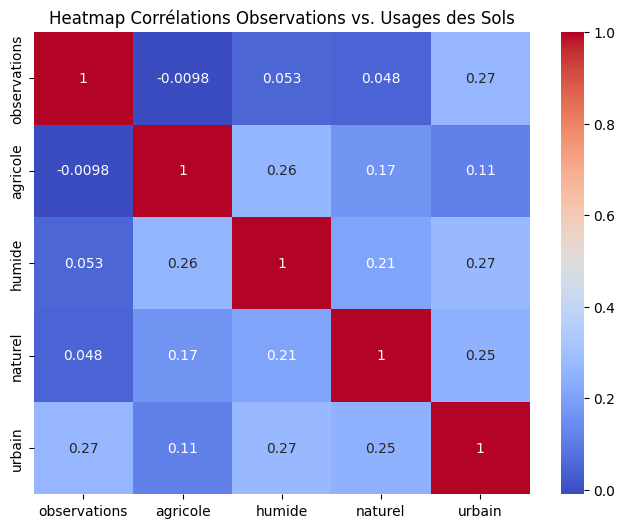

In [5]:
# 2. Corrélations
# 2.1 Avec usages des sols : Corrélations Pearson
# Grouper par commune pour corrélations (moyennes surfaces vs. count obs)
df_group_commune = df.groupby('codeInseeCommune').agg(
    observations=('codeInseeCommune', 'size'),  # Utiliser named aggregation pour compter les observations
    agricole=('agricole', 'mean'),
    humide=('humide', 'mean'),
    naturel=('naturel', 'mean'),
    urbain=('urbain', 'mean')
).reset_index()

# Gérer les NaN : supprimer les lignes avec NaN dans les colonnes pertinentes
df_group_commune = df_group_commune.dropna(subset=['observations', 'agricole', 'humide', 'naturel', 'urbain'])

# Matrice de corrélations
corr_matrix = df_group_commune[['observations', 'agricole', 'humide', 'naturel', 'urbain']].corr(method='pearson')
print("Matrice de corrélations Pearson avec usages des sols :\n", corr_matrix)

# Heatmap visualisation
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap Corrélations Observations vs. Usages des Sols')
plt.show()

In [6]:
# 2.2 Régressions exemple (linéaire : observations ~ naturel + urbain)
X = df_group_commune[['naturel', 'urbain', 'agricole', 'humide']]
X = sm.add_constant(X)  # Ajouter constante
y = df_group_commune['observations']
model = sm.OLS(y, X).fit()
print("Résumé de la régression linéaire :\n", model.summary())

# Focus spécifique : naturel pour oiseaux
df_oiseaux_group = df[df['etiquette'] == 'oiseau'].groupby('codeInseeCommune').agg(
    obs_oiseaux=('codeInseeCommune', 'size'),
    naturel=('naturel', 'mean')
).reset_index()

# Gérer les NaN
df_oiseaux_group = df_oiseaux_group.dropna(subset=['obs_oiseaux', 'naturel'])

corr_oiseaux_naturel, p = pearsonr(df_oiseaux_group['obs_oiseaux'], df_oiseaux_group['naturel'])
print(f"Corrélation Pearson oiseaux-naturel : {corr_oiseaux_naturel} (p-value: {p})")

# Similaire pour papillons-humide, plantes-agricole (adaptez filtres étiquette)
df_papillons_group = df[df['etiquette'] == 'papillon'].groupby('codeInseeCommune').agg(
    obs_papillons=('codeInseeCommune', 'size'),
    humide=('humide', 'mean')
).reset_index()

# Gérer les NaN
df_papillons_group = df_papillons_group.dropna(subset=['obs_papillons', 'humide'])

if not df_papillons_group.empty:
    corr_pap_humide, p = pearsonr(df_papillons_group['obs_papillons'], df_papillons_group['humide'])
    print(f"Corrélation Pearson papillons-humide : {corr_pap_humide} (p-value: {p})")

Résumé de la régression linéaire :
                             OLS Regression Results                            
Dep. Variable:           observations   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     65.35
Date:                Mon, 03 Nov 2025   Prob (F-statistic):           3.14e-53
Time:                        20:15:36   Log-Likelihood:                -29398.
No. Observations:                3242   AIC:                         5.881e+04
Df Residuals:                    3237   BIC:                         5.884e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        292

Corrélation Pearson densité-population : -0.02151562907299319 (p-value: 0.22067382159132004)


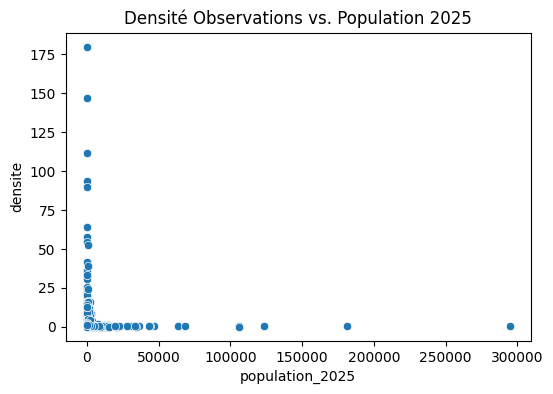

In [7]:
# 2.3 Avec population : Densité obs vs. population2025
df_densite = df.groupby('codeInseeCommune').agg(
    population_2025=('population 2025', 'mean'),
    observations=('codeInseeCommune', 'size')
).reset_index()

# Gérer les NaN
df_densite = df_densite.dropna(subset=['population_2025', 'observations'])

df_densite['densite'] = df_densite['observations'] / df_densite['population_2025'].replace(0, 1)  # Éviter div/0

# Gérer les NaN dans densite (si population_2025 cause issues, mais déjà géré)
df_densite = df_densite.dropna(subset=['densite', 'population_2025'])

corr_pop, p = pearsonr(df_densite['densite'], df_densite['population_2025'])
print(f"Corrélation Pearson densité-population : {corr_pop} (p-value: {p})")

# Scatter plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x='population_2025', y='densite', data=df_densite)
plt.title('Densité Observations vs. Population 2025')
plt.show()

Déclins pour espèces sensibles :
                                pre_2000  post_2000  variation
espece                                                       
Upupa epops                         0.0         27       27.0
Muscicapa striata                   0.0        201      201.0
Dendrocopos minor                   0.0        360      360.0
Emberiza cirlus                     0.0        525      525.0
Turdus iliacus                      0.0        627      627.0
Regulus regulus                     0.0        645      645.0
Emberiza citrinella                 0.0        864      864.0
Psittacula krameri                  0.0       1116     1116.0
Apus apus                           0.0       1755     1755.0
Linaria cannabina                   0.0       1926     1926.0
Lophophanes cristatus               0.0       2439     2439.0
Serinus serinus                     0.0       2577     2577.0
Delichon urbicum                    0.0       2601     2601.0
Phoenicurus phoenicurus             

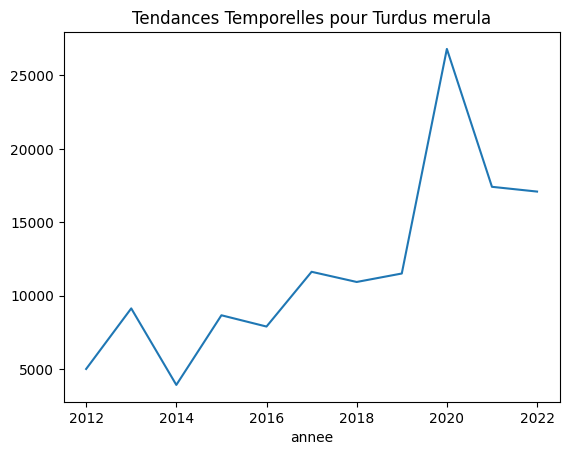

In [8]:
# 2.4 Focus espèces sensibles (especeEvalueeLR ou reglementee)
# Note: Adaptez si 'especeDirectiveEuropeenne' existe ; ici on utilise especeEvalueeLR et especeReglementee
df_sensibles = df[(df['especeEvalueeLR'] == True) | (df['especeReglementee'] == True)]

# Déclins temporels : pre-2000 vs. post-2000
pre_2000 = df_sensibles[df_sensibles['annee'] < 2000].groupby('espece').size()
post_2000 = df_sensibles[df_sensibles['annee'] >= 2000].groupby('espece').size()
declins = pd.concat([pre_2000, post_2000], axis=1, keys=['pre_2000', 'post_2000']).fillna(0)
declins['variation'] = (declins['post_2000'] - declins['pre_2000']) / (declins['pre_2000'] + 1)  # +1 évite div/0
print("Déclins pour espèces sensibles :\n", declins.sort_values('variation'))

# Graphique exemple pour top espèce sensible
top_sensible = df_sensibles['espece'].value_counts().idxmax()
df_top_sensible = df_sensibles[df_sensibles['espece'] == top_sensible]
stats_annee_sensible = df_top_sensible['annee'].value_counts().sort_index()
stats_annee_sensible.plot(kind='line', title=f"Tendances Temporelles pour {top_sensible}")
plt.show()

In [9]:
communes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15354 entries, 0 to 15353
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   codeINSEE        15354 non-null  int64 
 1   departement      15354 non-null  object
 2   commune          15354 non-null  object
 3   latCentroide     15354 non-null  object
 4   lonCentroide     15354 non-null  object
 5   population 2025  15354 non-null  int64 
 6   annee            15354 non-null  int64 
 7   urbain           15354 non-null  object
 8   agricole         15354 non-null  object
 9   naturel          15354 non-null  object
 10  humide           15354 non-null  object
 11  eau              15354 non-null  object
 12  surfaceTotale    15354 non-null  object
dtypes: int64(3), object(10)
memory usage: 1.5+ MB


In [10]:
# 3. Prise en compte des biais
# 3.1 Normaliser par surface totale ou effort
# Ajouter surface totale depuis communes (merge si pas déjà)
if 'surfaceTotale' in communes.columns:
    df = df.merge(communes[['codeINSEE', 'surfaceTotale']], left_on='codeInseeCommune', right_on='codeINSEE', how='left')
    df = df.drop(columns=['codeINSEE'])  # Supprimer la colonne dupliquée après merge
    
    # Nettoyer et convertir surfaceTotale en float (remplacer ',' par '.' et gérer NaN)
    df['surfaceTotale'] = pd.to_numeric(df['surfaceTotale'].astype(str).str.replace(',', '.'), errors='coerce')
else:
    print("Ajoutez surfaceTotale à communes.csv si disponible.")

# Normaliser par surface (obs / km²)
df_group_norm_surface = df.groupby('codeInseeCommune').agg(
    observations=('codeInseeCommune', 'size'),
    surfaceTotale=('surfaceTotale', 'mean')
).reset_index()

# Gérer les NaN
df_group_norm_surface = df_group_norm_surface.dropna(subset=['observations', 'surfaceTotale'])

df_group_norm_surface['norm_surface'] = df_group_norm_surface['observations'] / df_group_norm_surface['surfaceTotale'].replace(0, 1)
print("Observations normalisées par surface :\n", df_group_norm_surface.sort_values('norm_surface', ascending=False).head(10))

# Normaliser par effort (obs uniques / obsID uniques par commune/annee - déjà en 3.1 du code précédent)
effort = df.groupby(['codeInseeCommune', 'annee'])['obsID'].nunique().reset_index(name='effort')
obs_total = df.groupby(['codeInseeCommune', 'annee']).size().reset_index(name='observations')
df_biais = pd.merge(obs_total, effort, on=['codeInseeCommune', 'annee'])
df_biais['norm_effort'] = df_biais['observations'] / df_biais['effort']
print("Observations normalisées par effort :\n", df_biais.sort_values('norm_effort', ascending=False).head(10))

# Utiliser ces normalisées pour re-corréler (ex. avec naturel)
df_norm_group = df_biais.groupby('codeInseeCommune')['norm_effort'].mean().reset_index()
df_norm_group = df_norm_group.merge(df_group_commune[['codeInseeCommune', 'naturel']], on='codeInseeCommune')

# Gérer les NaN
df_norm_group = df_norm_group.dropna(subset=['norm_effort', 'naturel'])

corr_norm, p = pearsonr(df_norm_group['norm_effort'], df_norm_group['naturel'])
print(f"Corrélation normalisée effort-naturel : {corr_norm} (p-value: {p})")

Observations normalisées par surface :
       codeInseeCommune  observations  surfaceTotale  norm_surface
2709             68029        171909     428.066667    401.593988
3013             88073         90072     301.230000    299.014042
1973             57205         56880     607.900000     93.568021
2627             67476         36387     391.766667     92.879265
1914             57096        115740    1275.066667     90.771724
1113             52275         41562     460.698333     90.215217
2222             57616         38070     454.466667     83.768520
1489             54439         28503     374.733333     76.062089
360              10104         83286    1133.548667     73.473687
2362             67087         53127     765.300000     69.419835
Observations normalisées par effort :
       codeInseeCommune  annee  observations  effort  norm_effort
1229             10081   2015         35361       1      35361.0
8959             67476   2020         34200       1      34200.0


Observations pré-COVID :
 annee
2010      9117
2011      7182
2012    214173
2013    378621
2014    139059
2015    333918
2016    308295
2017    413082
2018    484389
2019    495208
dtype: int64
Observations post-COVID :
 annee
2020    1027881
2021     651510
2022     629883
2023      11277
2024       1143
dtype: int64
Taux moyen pré-COVID : 278304.4, post-COVID : 464338.8 (variation : 66.85%)


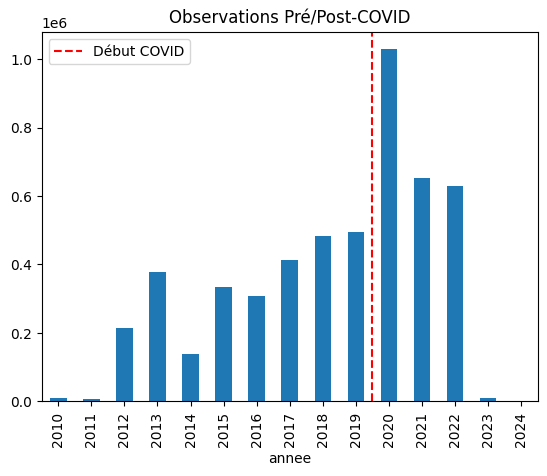

In [11]:
# 3.2 Comparer pré/post-COVID
pre_covid = df[df['annee'] < 2020].groupby('annee').size()
post_covid = df[df['annee'] >= 2020].groupby('annee').size()  # Inclut 2020-2021 comme dans code précédent
print("Observations pré-COVID :\n", pre_covid)
print("Observations post-COVID :\n", post_covid)

# Taux moyen pré vs. post
moy_pre = pre_covid.mean()
moy_post = post_covid.mean()
print(f"Taux moyen pré-COVID : {moy_pre}, post-COVID : {moy_post} (variation : {(moy_post - moy_pre)/moy_pre * 100:.2f}%)")

# Graphique
pd.concat([pre_covid, post_covid]).plot(kind='bar', title='Observations Pré/Post-COVID')
plt.axvline(x=len(pre_covid)-0.5, color='red', linestyle='--', label='Début COVID')
plt.legend()
plt.show()

In [12]:
# 3.3 Tests stats supplémentaires (ex. Chi² pour associations espèce-habitat)
# Exemple : Contingence espèce (top 5) vs. habitat (bins pour naturel haut/bas)
top_especes = df['espece'].value_counts().head(5).index
df_chi = df[df['espece'].isin(top_especes)].copy()

# Gérer les NaN dans 'naturel' avant pd.cut
df_chi = df_chi.dropna(subset=['naturel'])

df_chi['habitat_naturel'] = pd.cut(df_chi['naturel'], bins=2, labels=['Bas', 'Haut'])
contingency = pd.crosstab(df_chi['espece'], df_chi['habitat_naturel'])
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Test Chi² espèce-habitat : chi2={chi2}, p-value={p}")
print("Table de contingence :\n", contingency)

Test Chi² espèce-habitat : chi2=20.046713359637042, p-value=0.0004889059962973442
Table de contingence :
 habitat_naturel         Bas  Haut
espece                           
Cyanistes caeruleus  419229   594
Fringilla coelebs    303579   351
Parus major          482607   738
Passer domesticus    472473   630
Turdus merula        389529   531


In [15]:
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import seasonal_decompose

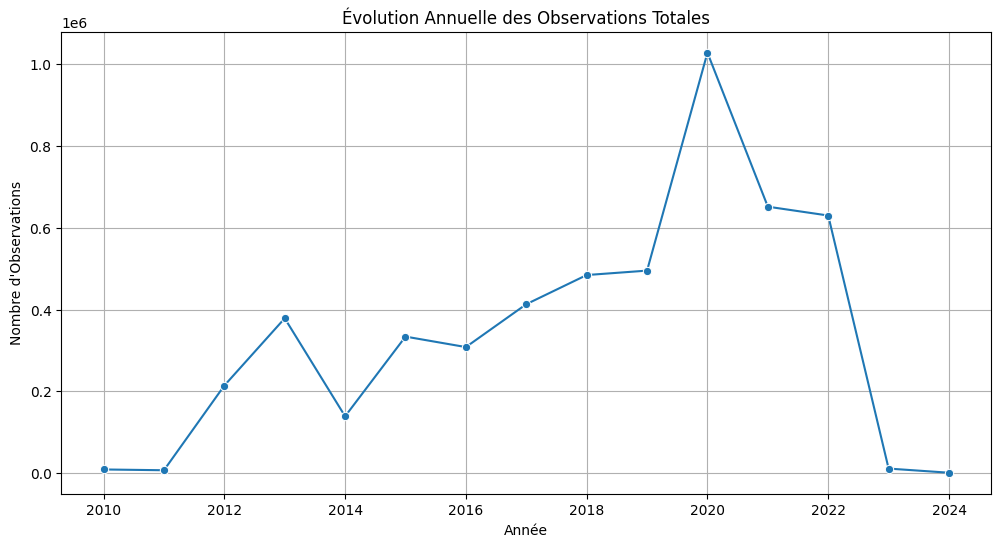

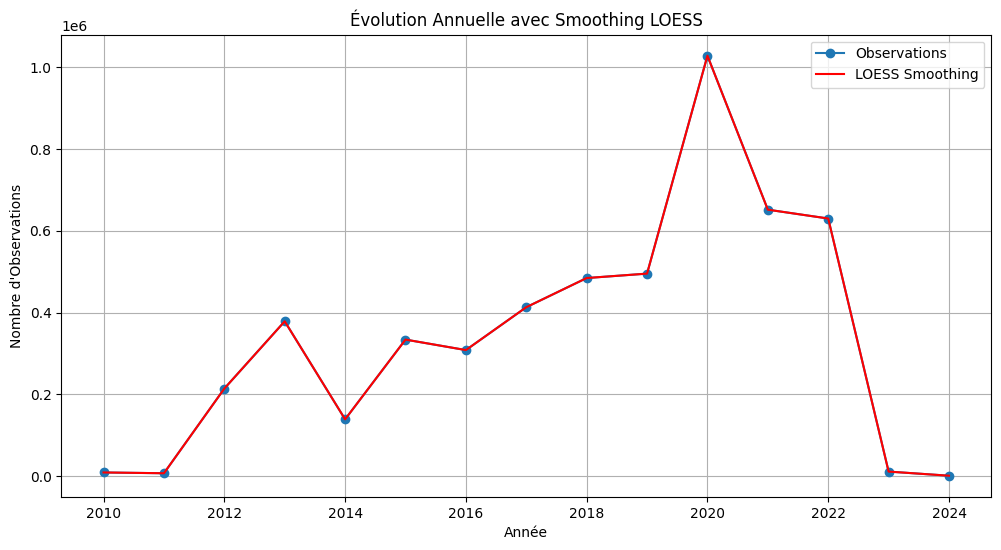

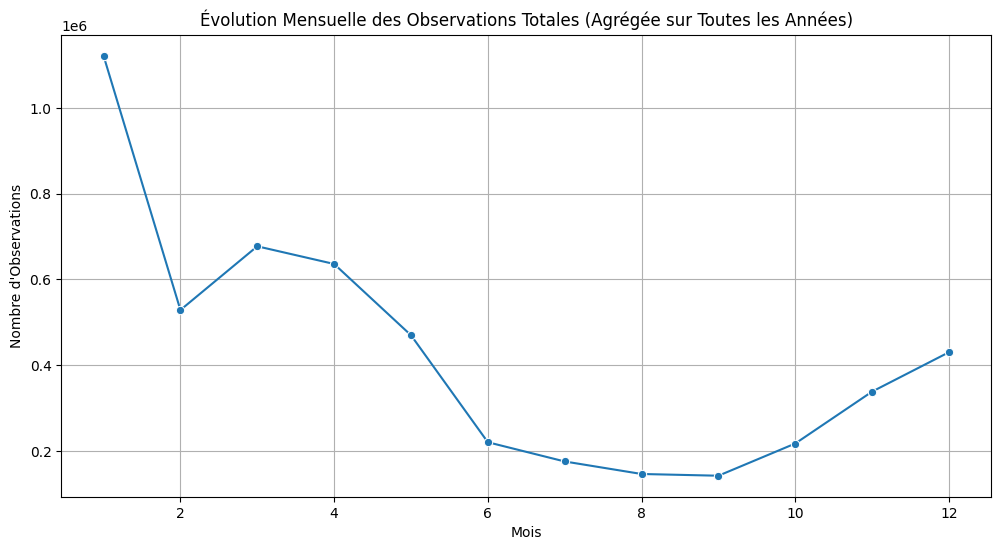

In [16]:
# 1. Série temporelle : Évolution annuelle/mensuelle des observations totales ou par espèce/catégorie
# 1.1 Évolution annuelle totale
obs_annuelles = df.groupby('annee').size().reset_index(name='observations')
plt.figure(figsize=(12, 6))
sns.lineplot(x='annee', y='observations', data=obs_annuelles, marker='o')
plt.title("Évolution Annuelle des Observations Totales")
plt.xlabel("Année")
plt.ylabel("Nombre d'Observations")
plt.grid(True)
plt.show()

# Avec smoothing LOESS
lowess_res = lowess(obs_annuelles['observations'], obs_annuelles['annee'], frac=0.2)
plt.figure(figsize=(12, 6))
plt.plot(obs_annuelles['annee'], obs_annuelles['observations'], marker='o', label='Observations')
plt.plot(obs_annuelles['annee'], lowess_res[:, 1], color='red', label='LOESS Smoothing')
plt.title("Évolution Annuelle avec Smoothing LOESS")
plt.xlabel("Année")
plt.ylabel("Nombre d'Observations")
plt.legend()
plt.grid(True)
plt.show()

# 1.2 Par mois (agrégation mensuelle sur toutes les années)
obs_mensuelles = df.groupby('mois').size().reset_index(name='observations')
plt.figure(figsize=(12, 6))
sns.lineplot(x='mois', y='observations', data=obs_mensuelles, marker='o')
plt.title("Évolution Mensuelle des Observations Totales (Agrégée sur Toutes les Années)")
plt.xlabel("Mois")
plt.ylabel("Nombre d'Observations")
plt.grid(True)
plt.show()

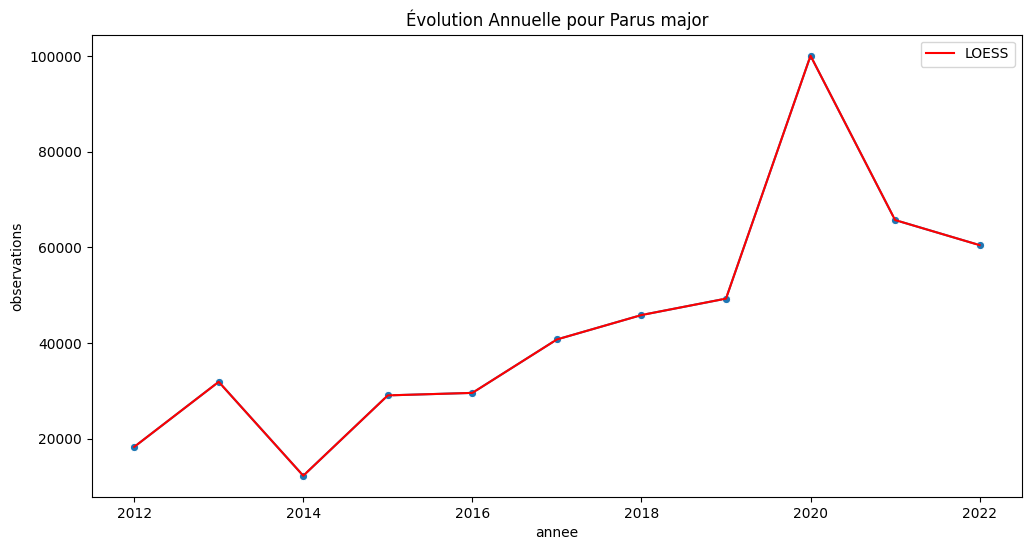

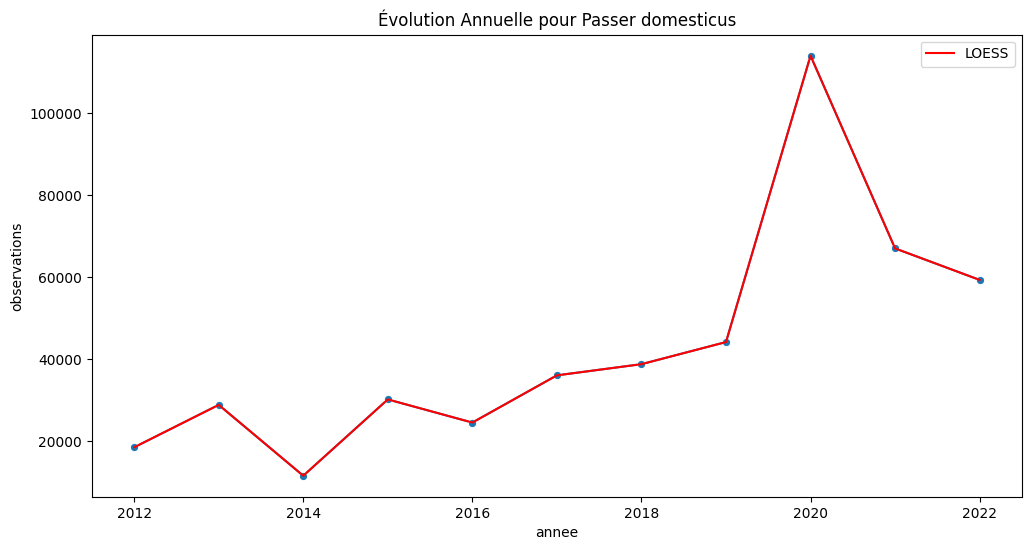

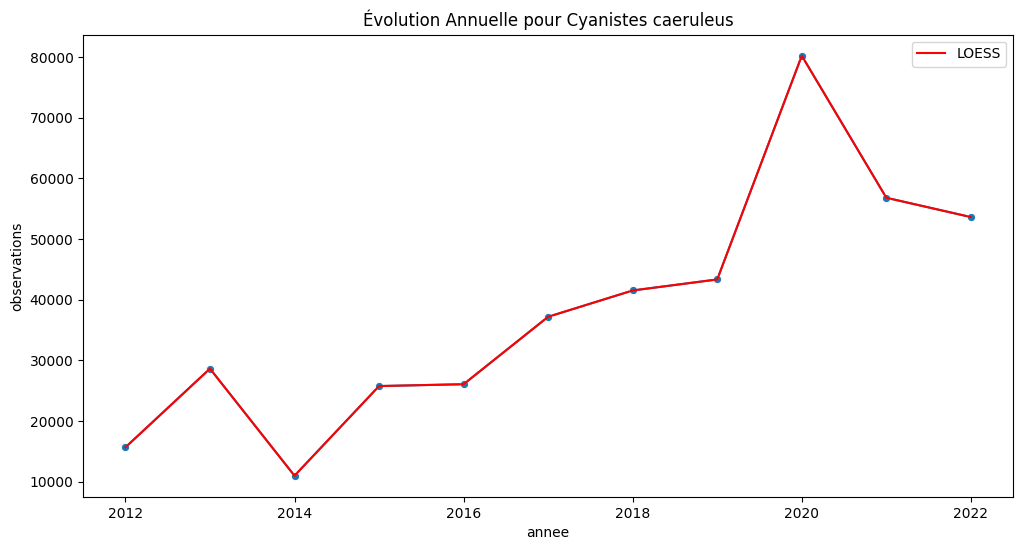

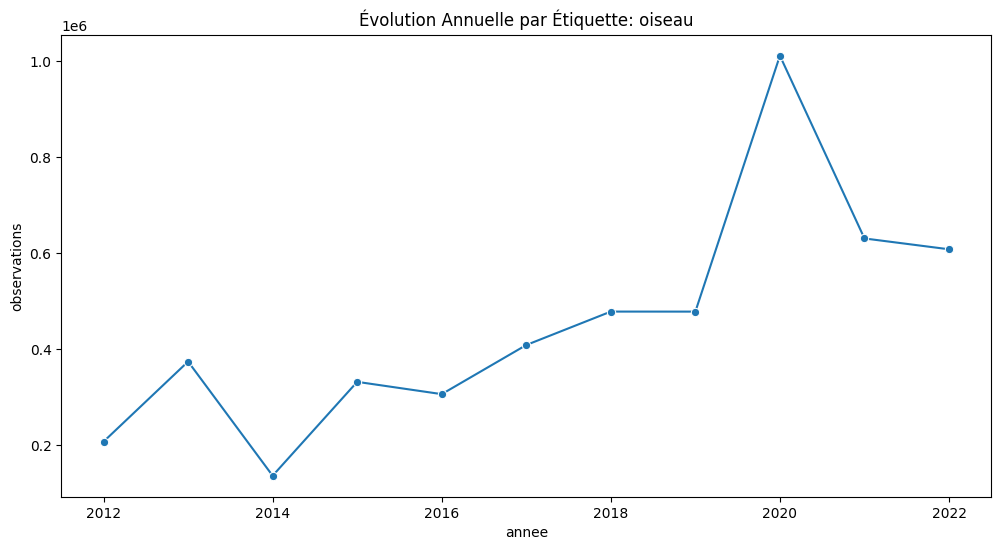

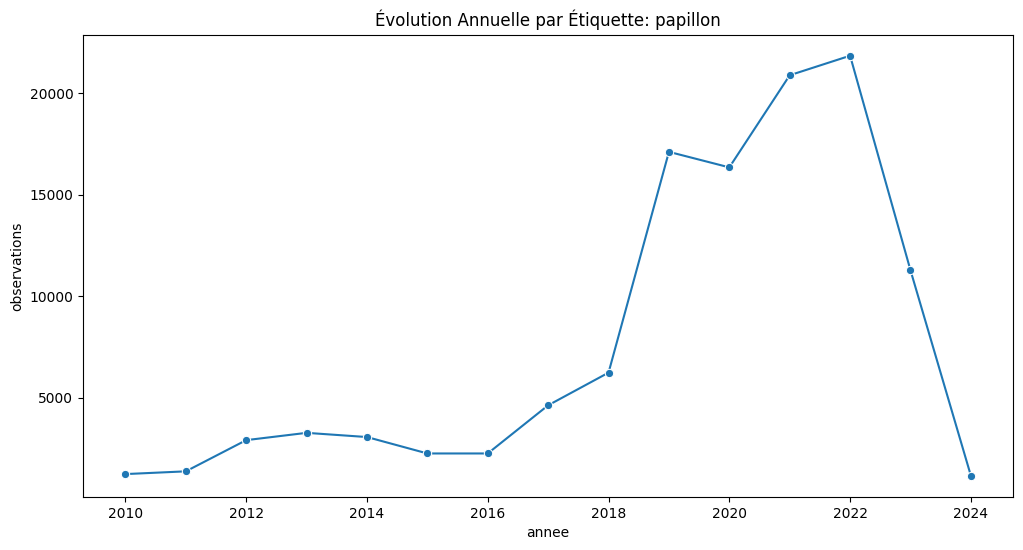

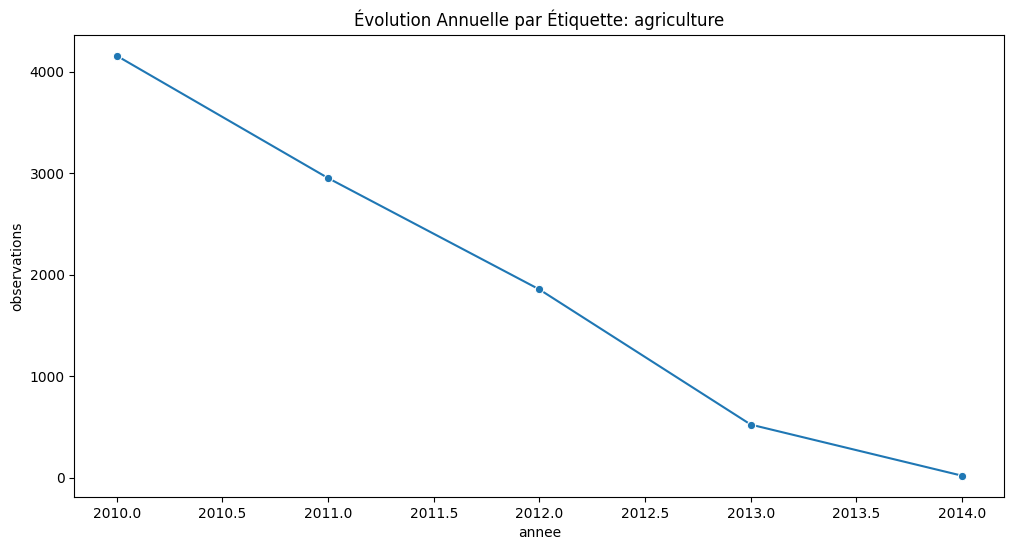

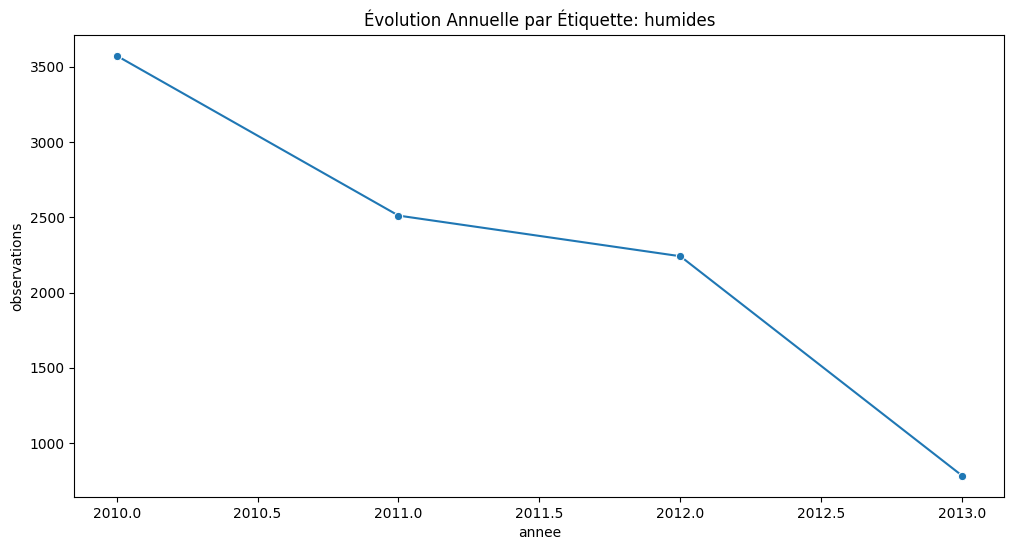

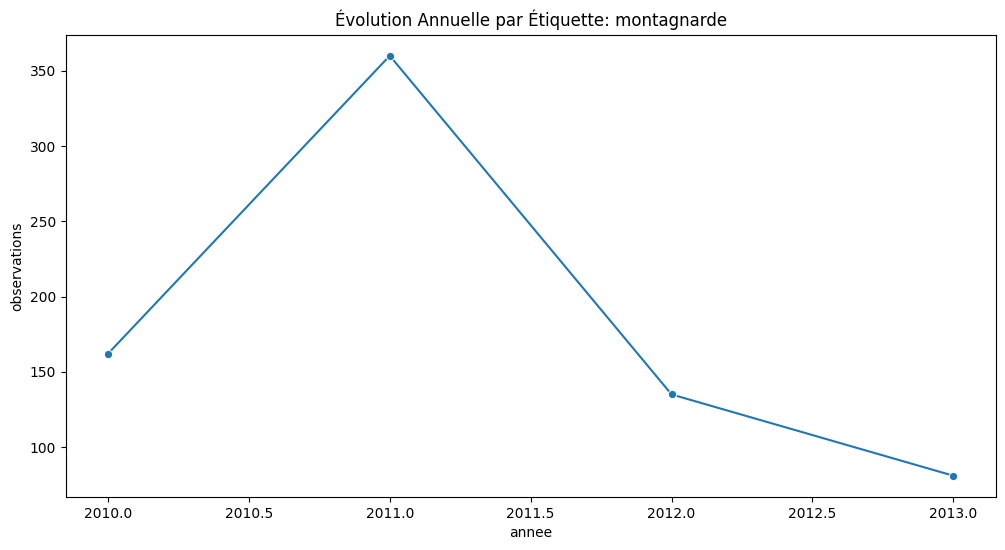

In [17]:
# 1.3 Par espèce/catégorie (exemple pour top espèces et étiquettes)
# Top espèces
top_especes = df['espece'].value_counts().head(3).index  # Top 3 pour exemple
for espece in top_especes:
    df_espece = df[df['espece'] == espece].groupby('annee').size().reset_index(name='observations')
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='annee', y='observations', data=df_espece, marker='o')
    lowess_res = lowess(df_espece['observations'], df_espece['annee'], frac=0.2)
    plt.plot(df_espece['annee'], lowess_res[:, 1], color='red', label='LOESS')
    plt.title(f"Évolution Annuelle pour {espece}")
    plt.legend()
    plt.show()

# Par étiquette (oiseau, papillon, plante)
for etiquette in df['etiquette'].unique():
    df_etiq = df[df['etiquette'] == etiquette].groupby('annee').size().reset_index(name='observations')
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='annee', y='observations', data=df_etiq, marker='o')
    plt.title(f"Évolution Annuelle par Étiquette: {etiquette}")
    plt.show()

Moyenne pré-1990: nan 
Moyenne post-1990: 340315.86666666664


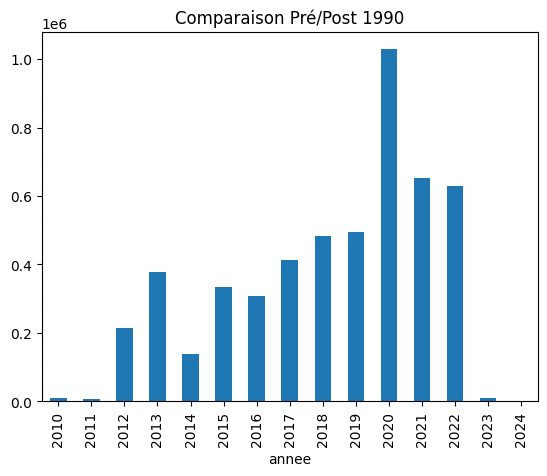

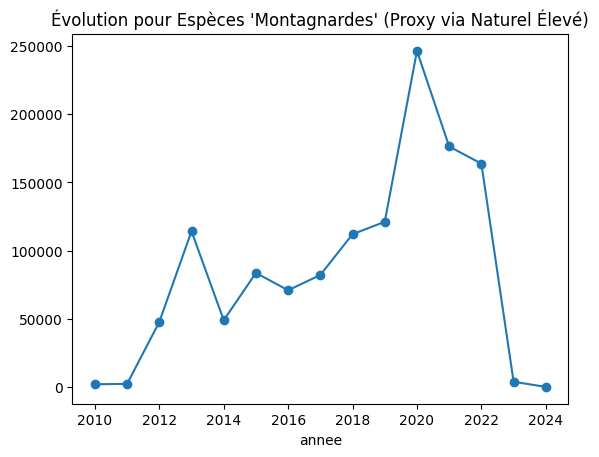

Observations montagnardes pré-2000: 0, post-2000: 1276101


In [18]:
# 3. Changements long-terme : Comparer époques
# 3.1 Avant/après 1990 (industrialisation)
pre_1990 = df[df['annee'] < 1990].groupby('annee').size()
post_1990 = df[df['annee'] >= 1990].groupby('annee').size()
print("Moyenne pré-1990:", pre_1990.mean(), "\nMoyenne post-1990:", post_1990.mean())

# Graphique comparaison
pd.concat([pre_1990, post_1990]).plot(kind='bar', title="Comparaison Pré/Post 1990")
plt.axvline(x=len(pre_1990)-0.5, color='red', linestyle='--')
plt.show()

# 3.2 Impacts climatiques via montagnardes sensibles (approximation: espèces avec 'naturel' élevé, e.g. > quantile 0.75)
df_montagnardes = df[df['naturel'] > df['naturel'].quantile(0.75)]  # Proxy pour montagnardes
obs_mont_ann = df_montagnardes.groupby('annee').size()
obs_mont_ann.plot(kind='line', title="Évolution pour Espèces 'Montagnardes' (Proxy via Naturel Élevé)", marker='o')
plt.show()

# Comparaison pré/post 2000 (ex. pour réchauffement)
pre_2000_mont = df_montagnardes[df_montagnardes['annee'] < 2000].shape[0]
post_2000_mont = df_montagnardes[df_montagnardes['annee'] >= 2000].shape[0]
print(f"Observations montagnardes pré-2000: {pre_2000_mont}, post-2000: {post_2000_mont}")

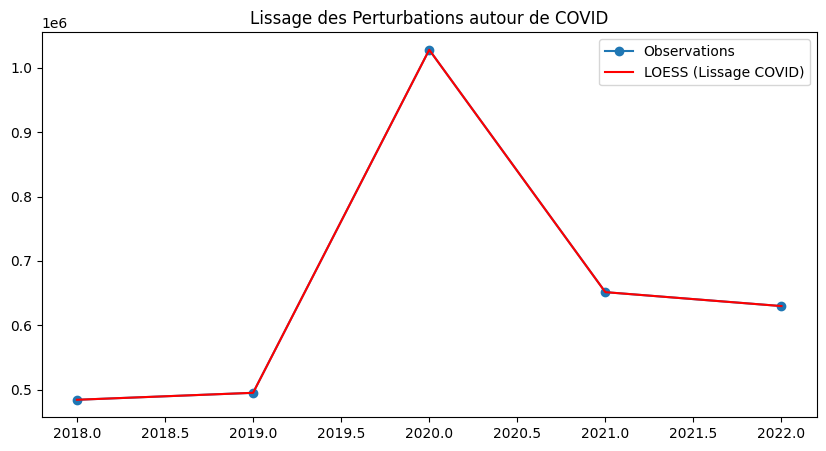

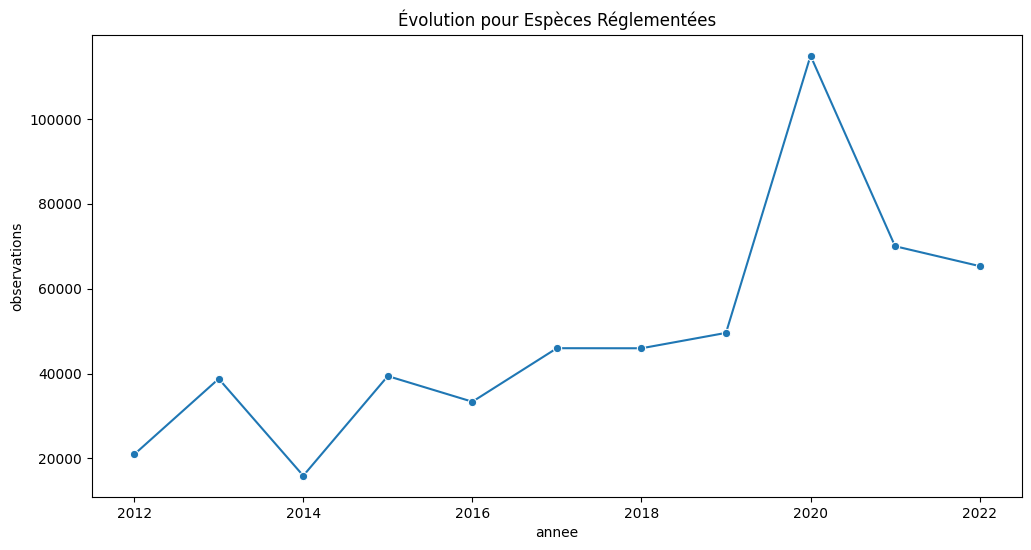

Moyenne pré-2010: nan, post-2010: 49109.72727272727 (impact protections?)


In [19]:
# 4. Prise en compte des biais
# 4.1 Utiliser LOESS pour lisser perturbations (ex. COVID)
# Déjà utilisé ci-dessus; exemple spécifique pour période COVID
df_covid_period = df[(df['annee'] >= 2018) & (df['annee'] <= 2022)].groupby('annee').size().reset_index(name='observations')
lowess_covid = lowess(df_covid_period['observations'], df_covid_period['annee'], frac=0.5)
plt.figure(figsize=(10, 5))
plt.plot(df_covid_period['annee'], df_covid_period['observations'], marker='o', label='Observations')
plt.plot(df_covid_period['annee'], lowess_covid[:, 1], color='red', label='LOESS (Lissage COVID)')
plt.title("Lissage des Perturbations autour de COVID")
plt.legend()
plt.show()

# 4.2 Focus sur espèces réglementées
df_reglementees = df[df['especeReglementee'] == True]
obs_reg_ann = df_reglementees.groupby('annee').size().reset_index(name='observations')
plt.figure(figsize=(12, 6))
sns.lineplot(x='annee', y='observations', data=obs_reg_ann, marker='o')
plt.title("Évolution pour Espèces Réglementées")
plt.show()

# Discussion protections: comparer pré/post régulation (assumer post-2010 par exemple)
pre_reg = obs_reg_ann[obs_reg_ann['annee'] < 2010]['observations'].mean()
post_reg = obs_reg_ann[obs_reg_ann['annee'] >= 2010]['observations'].mean()
print(f"Moyenne pré-2010: {pre_reg}, post-2010: {post_reg} (impact protections?)")